**Here is the code for automatic grouping of VA scan results.**


To begin, please upload the VA result file intended for automatic grouping by following these steps

1.   Click the Upload button on the right side of the screen to select your file
2.   Once uploaded, you will see your file listed and ready to use




---




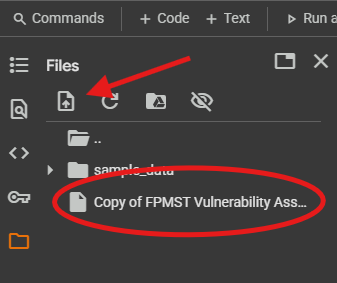



---




Please fill in the required information below

1.   filePath (The file path where you upload the file, which will also be used to save the file after processing)


```
If you upload the file as described, it is usually located at
`/content/your_file_Here.xlsx`

```

2. sheet_name (Specify the sheet name to group the data)

3.   patterns (A dictionary containing regex patterns for grouping)


```
The syntax follows the format below
'GroupNameResult': r'RegexPattern'
```








In [2]:
import pandas as pd
import re
from google.colab import drive
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter

In [3]:
# filePath Here
filePath = '/content/XXX Vulnerability Assessment Revisit Tracking.xlsx'

# sheet name Here
df = pd.read_excel(filePath, sheet_name='XXX', engine='openpyxl')

# patterns Here
patterns = {
    'Test EiEi': r'^Test.*',
}

Once you have provided the required information and run the code

# **Code section**

In [4]:
df

Ip                                 Vulnerability Name    Port  \
0    10.5.131.102  Diffie-Hellman Ephemeral Key Exchange DoS Vuln...  3389.0   
1    10.5.131.102  SSL/TLS: Renegotiation DoS Vulnerability (CVE-...  5693.0   
2    10.5.131.102   DCE/RPC and MSRPC Services Enumeration Reporting   135.0   
3    10.5.131.102   SSL/TLS: Deprecated < TLSv1.2 Protocol Detection  3389.0   
4    10.5.131.102              TCP Timestamps Information Disclosure     NaN   
..            ...                                                ...     ...   
178     10.5.87.3                    Services Running Port Detection  5693.0   
179     10.5.87.3                    Services Running Port Detection  5693.0   
180     10.5.87.3  SSL/TLS: HTTP Strict Transport Security (HSTS)...   443.0   
181     10.5.87.3  SSL/TLS: HTTP Strict Transport Security (HSTS)...  5693.0   
182     10.5.87.3                    Services Running Port Detection  5985.0   

                                                  CVEs  \
0         CVE-2002-20001,CVE-2022-40735,CVE-2024-41996   
1                          CVE-2011-1473,CVE-2011-5094   
2                                                  NaN   
3    CVE-2011-3389,CVE-2015-0204,CVE-2023-41928,CVE...   
4                                                  NaN   
..                                                 ...   
178                                                NaN   
179                                                NaN   
180                                                NaN   
181                                                NaN   
182                                                NaN   

                                     Affected Versions  CVSS Severity  \
0                                                  NaN   7.5     High   
1    Every SSL/TLS service which does not properly ...   5.0   Medium   
2                                                  NaN   5.0   Medium   
3    - All services providing an encrypted communic...   4.3   Medium   
4    TCP implementations that implement RFC1323/RFC...   2.6      Low   
..                                                 ...   ...      ...   
178                                                NaN   0.0      Log   
179                                                NaN   0.0      Log   
180                                                NaN   0.0      Log   
181                                                NaN   0.0      Log   
182                                                NaN   0.0      Log   

                                             Detection  \
0    DHE' cipher suites accepted by this service vi...   
1    The following indicates that the remote SSL/TL...   
2    Here is the list of DCE/RPC or MSRPC services ...   
3    In addition to TLSv1.2+ the service is also pr...   
4    It was detected that the host implements RFC13...   
..                                                 ...   
178       A TLScustom server answered on this port\n\n   
179  A web server is running on this port through S...   
180  The remote web server is not enforcing HSTS.\n...   
181  The remote web server is not enforcing HSTS.\n...   
182             A web server is running on this port\n   

                                              Solution      
0    - DHE key exchange should be disabled if no ot... NaN  
1    Users should contact their vendors for specifi... NaN  
2               Filter incoming traffic to this ports. NaN  
3    Disable TLSv1.1 and below protocols and use TL... NaN  
4    To disable TCP timestamps on linux add the lin... NaN  
..                                                 ...  ..  
178  Please discover open ports running on the syst... NaN  
179  Please discover open ports running on the syst... NaN  
180  Enable HSTS or add / configure the required di... NaN  
181  Enable HSTS or add / configure the required di... NaN  
182  Please discover open ports running on the syst... NaN  

[183 rows x 10 columns]

In [ ]:
def customGroup(name, patternDict):
    for groupLabel, pattern  in patternDict.items():
        if re.match(pattern , name):
            return groupLabel
    return name

def cveSort(cve):
    match = re.match(r'CVE-(\d+)-(\d+)', cve)
    if match:
        year, num = match.groups()
        return int(year), int(num)
    return (0, 0)

result = []

ipUnique = df['Ip'].unique()

for ip in ipUnique:
    ipData = df[df['Ip'] == ip].copy()

    allPort = sorted(set(ipData['Port'].dropna().astype(int)))
    allPortStr = ','.join(str(p) for p in allPort)

    groupedNames = []
    for vulnName in ipData['Vulnerability Name']:
        finalGroup = customGroup(str(vulnName), patterns)
        groupedNames.append(finalGroup)
    ipData['GroupedName'] = groupedNames

    for afterGroup in ipData['GroupedName'].unique():
        vulnRows = ipData[ipData['GroupedName'] == afterGroup]

        if afterGroup == 'Services Running Port Detection':
            finalPorts = allPortStr
        else:
            ports = sorted(set(vulnRows['Port'].dropna().astype(int)))
            finalPorts = ','.join(str(p) for p in ports)

        cveList = sorted(set(vulnRows['CVEs'].dropna().astype(str)), key=cveSort, reverse=True)
        cves = ','.join(cveList)

        affected = ','.join(sorted(set(vulnRows['Affected Versions'].dropna().astype(str))))
        cvss = ','.join(sorted(set(vulnRows['CVSS'].dropna().astype(str))))
        severity = ','.join(sorted(set(vulnRows['Severity'].dropna().astype(str))))
        detection = ','.join(sorted(set(vulnRows['Detection'].dropna().astype(str))))
        solution = ','.join(sorted(set(vulnRows['Solution'].dropna().astype(str))))

        result.append({
            'Ip': ip,
            'Vulnerability Name': afterGroup,
            'Ports': finalPorts,
            'CVEs': cves,
            'Affected Versions': affected,
            'CVSS': cvss,
            'Severity': severity,
            'Detection': detection,
            'Solution': solution
        })

resultData = pd.DataFrame(result)

with pd.ExcelWriter(filePath, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    resultData.to_excel(writer, sheet_name='Duplicated Vuln', index=False)


/usr/local/lib/python3.12/dist-packages/openpyxl/packaging/relationship.py:118: UserWarning: xl/pivotCache/_rels/pivotCacheDefinition1.xml.rels contains invalid dependency definitions
  warn(msg)


In [6]:
wb = load_workbook(filePath)
ws = wb['Duplicated Vuln']

for row in range(1, ws.max_row + 1):
    ws.row_dimensions[row].height = 15.75

for col in range(1, ws.max_column + 1):
    col_letter = get_column_letter(col)
    ws.column_dimensions[col_letter].width = 20

wb.save(filePath)

# Once you run the code


---


the file will be overwritten with the grouped data, and you may download the result from the same file.